# Dataset

We used the dataset  from Kaggle [Animal Species Classification - V3](https://www.kaggle.com/datasets/utkarshsaxenadn/animal-image-classification-dataset).
The authors created it to to have a data set for classifying animal species.
It is licensed under the "CC0: Public Domain" license.

The dataset comes already with a train, validation and test split for a total of 15 different animal classes.
The training data contains 2000 images per class with 256x256 pixels per picture.
The validation set contains 100/200 images per class
and the testing data is filled with a random number
of images per class.

Since the project requires to have atleast 500 images per class and that 30% should be locked for the test set, 
we will only use the data contained in the training set and split it ourselves.
In the following code segments we split the data to 0.3 test and 0.7 training data.
From the 0.8 training data we split it again to reserve data for validation.
We use a hardcoded seed to ensure the same shuffle.
The training was precleaned to only contain the data directories for the 10 classes used in this project.

In [44]:
# Import dependencies
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True' #Workaround for kernel crash because multiple copies of the OpenMP runtime have been linked

import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow.keras import models
from tensorflow.keras import layers


In [45]:
#Set os env variable. Only required if not already set.
#This should point to the folder which contains the training data
os.environ["aiap_data_path"] = "C:/Users/mrcls/temp_dataset/animals/data"

In [55]:
data_path = os.environ["aiap_data_path"]
batch_size = 32 # the whole data will be split into a total of the amount of batches
img_height = 64 # The image will be resized when imported to this height
img_width = 64 # The image will be resized when imported to this width
img_channels = 3 #RGB
shuffle_seed = 1234 # The seed for the data shuffle
shuffle_enabled = True
test_data_ratio = 0.3
validation_data_ratio= 0.2
img_classes = [ #explicitly defined to avoid errors
    "Cow",
    "Dog",
    "Elephant",
    "Gorilla",
    "Hippo",
    "Lizard",
    "Monkey",
    "Panda",
    "Tiger",
    "Zebra"
    ]


In [56]:
#Load the data and split it to training & test
data = tf.keras.preprocessing.image_dataset_from_directory(
    data_path, #directory where data is located
    class_names=img_classes, #pass in names of classes
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=shuffle_enabled, #shuffle the data
    seed=shuffle_seed, #seed for the shuffling and transformations
    validation_split=test_data_ratio, #we reserve a ratio of the data for the test set
    subset="both", #return both test & training set
)
print("do not confuse the output here. we explicitly use the validation data as test data and split the training data again for the validation data")

Found 20000 files belonging to 10 classes.
Using 14000 files for training.
Using 6000 files for validation.
do not confuse the output here. we explicitly use the validation data as test data and split the training data again for the validation data


In [57]:
# print information about the data
print("data variable contains:",len(data),"elements")
training_data= data[0]
test_data = data[1]
assert isinstance(training_data, tf.data.Dataset)
assert isinstance(test_data, tf.data.Dataset)
print("training data size:",training_data.cardinality())
print("test data size:", test_data.cardinality())
print("class names:", training_data.class_names)


data variable contains: 2 elements
training data size: tf.Tensor(438, shape=(), dtype=int64)
test data size: tf.Tensor(188, shape=(), dtype=int64)
class names: ['Cow', 'Dog', 'Elephant', 'Gorilla', 'Hippo', 'Lizard', 'Monkey', 'Panda', 'Tiger', 'Zebra']


In [58]:
# finally split the current training data into a separate validation set
training_data_size = sum(1 for _ in training_data)
print(training_data_size, "batches")
validation_data_size = int(validation_data_ratio * training_data_size)
print(validation_data_size, "batches")
validation_data = training_data.take(validation_data_size)
class_names = training_data.class_names
training_data = training_data.skip(validation_data_size)

438 batches
87 batches


## Normalize Data
OFFLOAD TO TENSORFLOW FUNCTION

In [59]:
# Print the shape of the input data
print("Shape of training data:")
i = 0
for x, y in training_data:
    print(x.shape)
    print(y.shape)
    print("True label:", y[0])
    i=i+1
    if i>3:
        break

Shape of training data:
(32, 64, 64, 3)
(32,)
True label: tf.Tensor(6, shape=(), dtype=int32)
(32, 64, 64, 3)
(32,)
True label: tf.Tensor(6, shape=(), dtype=int32)
(32, 64, 64, 3)
(32,)
True label: tf.Tensor(4, shape=(), dtype=int32)
(32, 64, 64, 3)
(32,)
True label: tf.Tensor(2, shape=(), dtype=int32)


In [60]:
def printPixelValueRange(dataset):
    for image, _ in dataset.take(1):
        print(f"Max value: {np.max(image[0])}")
printPixelValueRange(training_data)
printPixelValueRange(validation_data)
printPixelValueRange(test_data)

Max value: 255.0
Max value: 253.25
Max value: 254.25


In [61]:
def normalize(image,label):
    image = tf.cast(image/255.0 ,tf.float32)
    return image,label

training_data = training_data.map(normalize)
validation_data = validation_data.map(normalize)
test_data = test_data.map(normalize)


printPixelValueRange(training_data)
printPixelValueRange(validation_data)
printPixelValueRange(test_data)

Max value: 0.9960784316062927
Max value: 0.9941176176071167
Max value: 0.9970588088035583


## Data Class Distribution

In [62]:
# Initialize counters for each class
class_counts_training = {class_name: 0 for class_name in class_names}
class_counts_validation = {class_name: 0 for class_name in class_names}
class_counts_test = {class_name: 0 for class_name in class_names}

# Iterate through the dataset to count occurrences of each class
for batch in training_data:
    labels = batch[1]  # Assuming labels are in the second element of each batch
    for label in labels:
        class_counts_training[class_names[label]] += 1

for batch in validation_data:
    labels = batch[1]  # Assuming labels are in the second element of each batch
    for label in labels:
        class_counts_validation[class_names[label]] += 1

for batch in test_data:
    labels = batch[1]  # Assuming labels are in the second element of each batch
    for label in labels:
        class_counts_test[class_names[label]] += 1

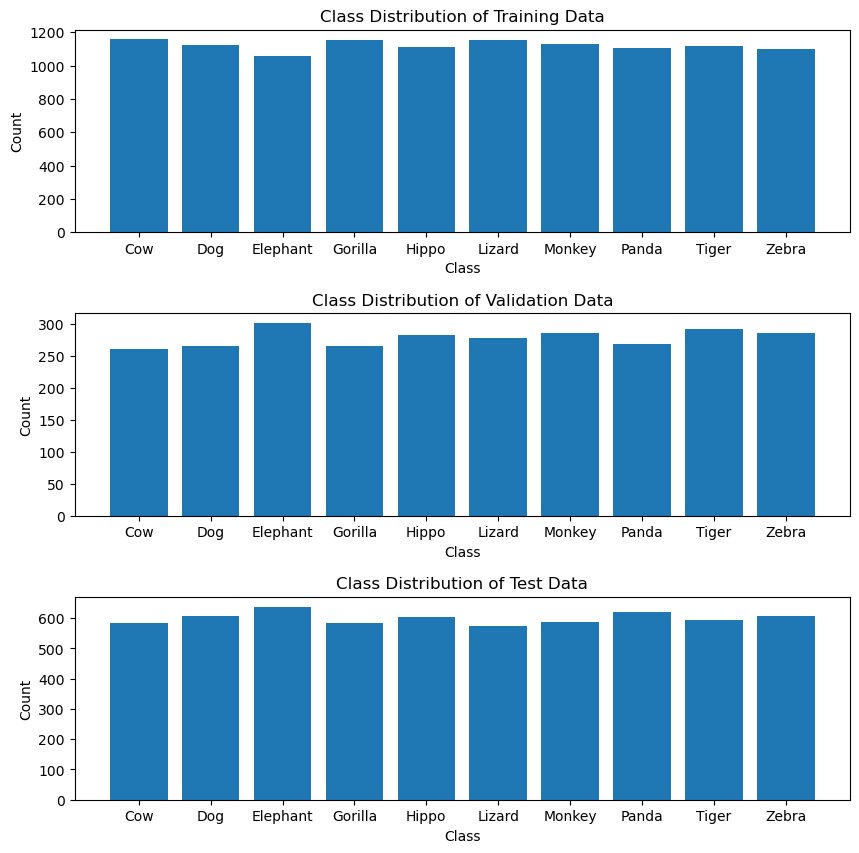

In [63]:

# Plot the class distribution
fig, (sub1, sub2, sub3) = plt.subplots(3, 1, figsize=(10, 10))
# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.4, hspace=0.4)

sub1.bar(class_counts_training.keys(), class_counts_training.values())
sub1.set_xlabel('Class')
sub1.set_ylabel('Count')
sub1.set_title('Class Distribution of Training Data')

sub2.bar(class_counts_validation.keys(), class_counts_validation.values())
sub2.set_xlabel('Class')
sub2.set_ylabel('Count')
sub2.set_title('Class Distribution of Validation Data')

sub3.bar(class_counts_test.keys(), class_counts_test.values())
sub3.set_xlabel('Class')
sub3.set_ylabel('Count')
sub3.set_title('Class Distribution of Test Data')
plt.show()

## Data Classes Plot

{'_input_dataset': <SkipDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>, '_use_inter_op_parallelism': True, '_preserve_cardinality': True, '_map_func': <tensorflow.python.data.ops.structured_function.StructuredFunctionWrapper object at 0x00000218AE2A2A10>, '_name': None, '_variant_tensor_attr': <tf.Tensor: shape=(), dtype=variant, value=<MapDatasetOp::Dataset>>, '_graph_attr': <tensorflow.python.framework.ops.Graph object at 0x000002188DAD90F0>, '_options_attr': <tensorflow.python.data.ops.options.Options object at 0x00000218AE2D93C0>}


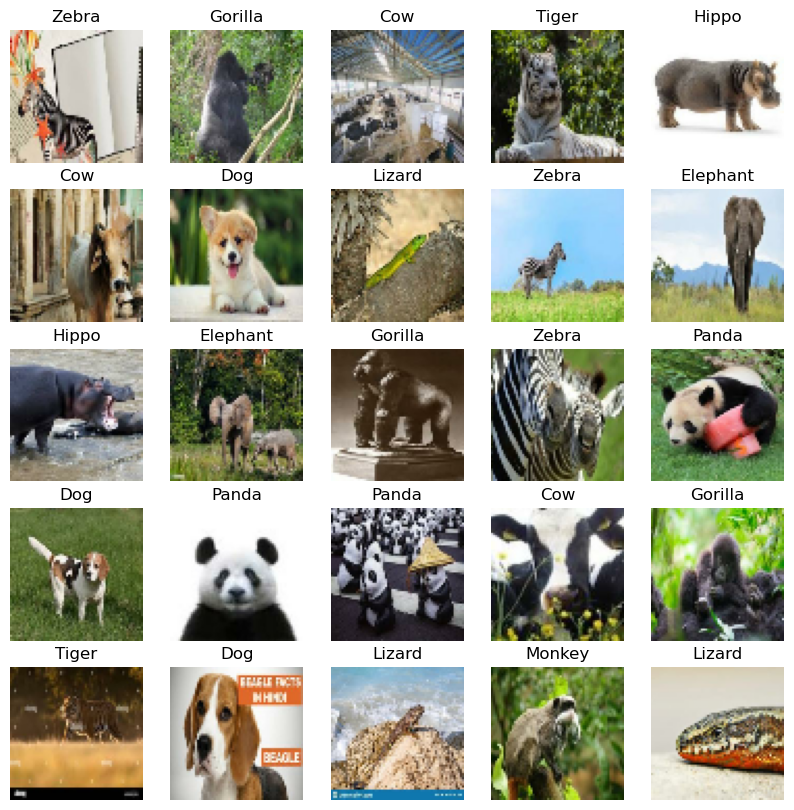

In [69]:
plt.figure(figsize=(10, 10))
print(vars(training_data))
for images, labels in training_data.take(1): # takes one batch
  for i in range(25):
    try:
      ax = plt.subplot(5, 5, i + 1)
      plt.imshow(images[i]) #.numpy().astype("uint8")
      plt.title(class_names[labels[i]])
      plt.axis("off")
    except Exception as e:
      print(f"Error at index {i}: {e}")

## Exploratory data analysis
Analyse and visualize your data set. How many samples per class do you have? Is the dataset 
balanced? Plot a few images. What is the range of values of the images? If it is [0 255] you need to 
scale or normalize the data

# Architecture 1
- 3 layers (without MaxPooling and Flatten)
- <2000 trainable parameters

In [72]:
simple_model = models.Sequential()
simple_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, img_channels)))
simple_model.add(layers.MaxPooling2D((32, 32)))
simple_model.add(layers.Flatten())
simple_model.add(layers.Dense(32, activation='relu'))
simple_model.add(layers.Dense(10))
simple_model.summary()

Model: "sequential_6"
_________________________________________________________________


 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 1, 1, 32)         0         
 2D)                                                             
                                                                 
 flatten_6 (Flatten)         (None, 32)                0         
                                                                 
 dense_12 (Dense)            (None, 32)                1056      
                                                                 
 dense_13 (Dense)            (None, 10)                330       
                                                                 
Total params: 2,282
Trainable params: 2,282
Non-trainable params: 0
_________________________________________________________________


In [73]:
simple_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [74]:
# history dictionary for successive combined trainings
combined_history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}

In [110]:
# save history data to disk
import json
# Save the dictionary to disk using JSON
with open('combined_history_simple_model.json', 'w') as f:
    json.dump(combined_history, f)

In [73]:
# load history data from disk
import json

with open('combined_history_simple_model.json', 'r') as f:
    combined_history = json.load(f)

In [75]:
# train
history = simple_model.fit(training_data, epochs=100, 
                           validation_data=validation_data)
# Update the combined_history with the first training session
for key in combined_history.keys():
    combined_history[key].extend(history.history[key])

Epoch 1/100


351/351 [==============================] - 5s 12ms/step - loss: 2.1898 - accuracy: 0.2123 - val_loss: 2.0294 - val_accuracy: 0.2942
Epoch 2/100
351/351 [==============================] - 5s 12ms/step - loss: 1.9433 - accuracy: 0.3119 - val_loss: 1.8775 - val_accuracy: 0.3261
Epoch 3/100
351/351 [==============================] - 5s 12ms/step - loss: 1.8449 - accuracy: 0.3468 - val_loss: 1.8122 - val_accuracy: 0.3495
Epoch 4/100
351/351 [==============================] - 5s 12ms/step - loss: 1.8019 - accuracy: 0.3590 - val_loss: 1.7990 - val_accuracy: 0.3470
Epoch 5/100
351/351 [==============================] - 5s 12ms/step - loss: 1.7741 - accuracy: 0.3724 - val_loss: 1.7553 - val_accuracy: 0.3757
Epoch 6/100
351/351 [==============================] - 5s 13ms/step - loss: 1.7554 - accuracy: 0.3814 - val_loss: 1.7430 - val_accuracy: 0.3879
Epoch 7/100
351/351 [==============================] - 5s 14ms/step - loss: 1.7389 - accuracy: 0.3849 - val_loss: 1.7425 - val_accuracy: 0.3757
Epoc

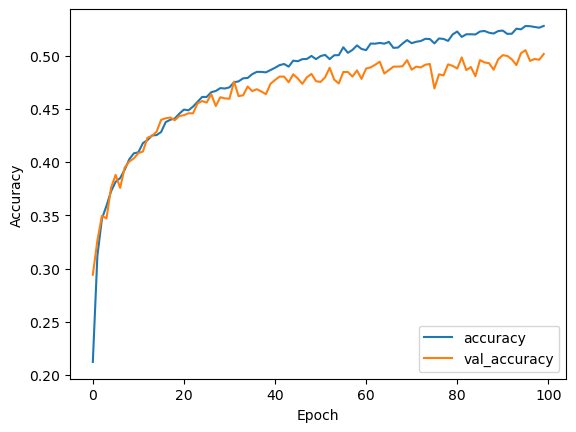

In [77]:
# plott accuracy
plt.plot(combined_history['accuracy'], label='accuracy')
plt.plot(combined_history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

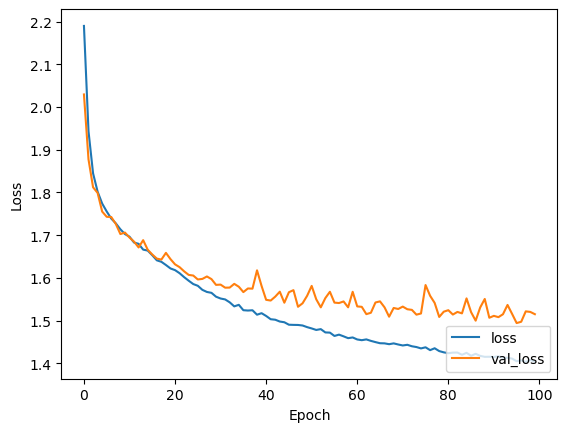

In [78]:
# plot error
plt.plot(combined_history['loss'], label = 'loss')
plt.plot(combined_history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()

In [79]:
print("validation data",simple_model.evaluate(training_data))
print("validation data",simple_model.evaluate(validation_data))

351/351 [==============================] - 2s 5ms/step - loss: 1.4045 - accuracy: 0.5280
validation data [1.404481053352356, 0.5279957056045532]
87/87 [==============================] - 1s 5ms/step - loss: 1.5086 - accuracy: 0.5040
validation data [1.508561372756958, 0.5039511322975159]


In [109]:
# save model to disk
simple_model.save("simple_model")

INFO:tensorflow:Assets written to: simple_model\assets


INFO:tensorflow:Assets written to: simple_model\assets


In [133]:
simple_model = tf.keras.models.load_model('simple_model')

## Confusion matrix
of the validation data.
Make 3 different plots for 3 different values of the 
'normalize' parameter (see https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html )

In [134]:
predicted_labels = np.array([])
true_labels = np.array([])

for x, y in training_data:
    predicted_labels = np.concatenate([predicted_labels,
                       np.argmax(simple_model(x), axis=-1)])
    true_labels = np.concatenate([true_labels, y])



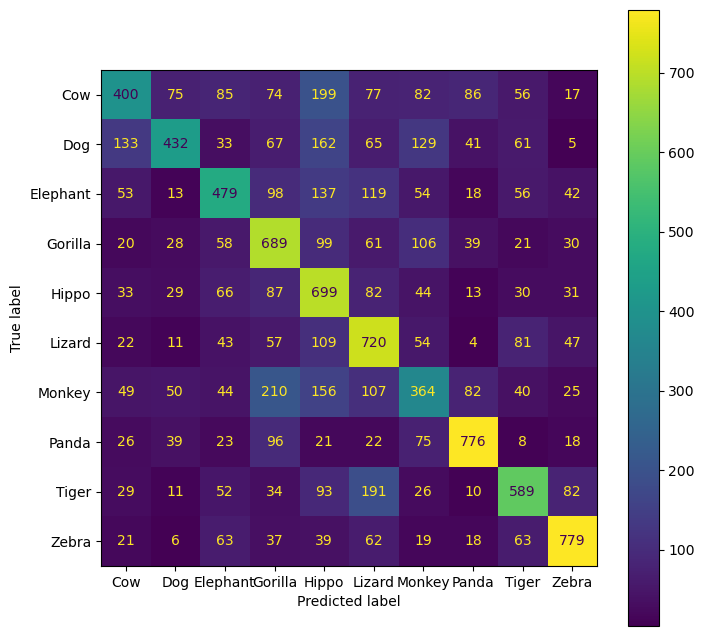

In [135]:
#predictions = simple_model.predict(training_data)
#predicted_labels = np.argmax(predictions, axis=1) 
#true_labels = np.concatenate([y.numpy() for _, y in training_data], axis=0) 
cm = confusion_matrix(true_labels, predicted_labels) 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax)
plt.show()

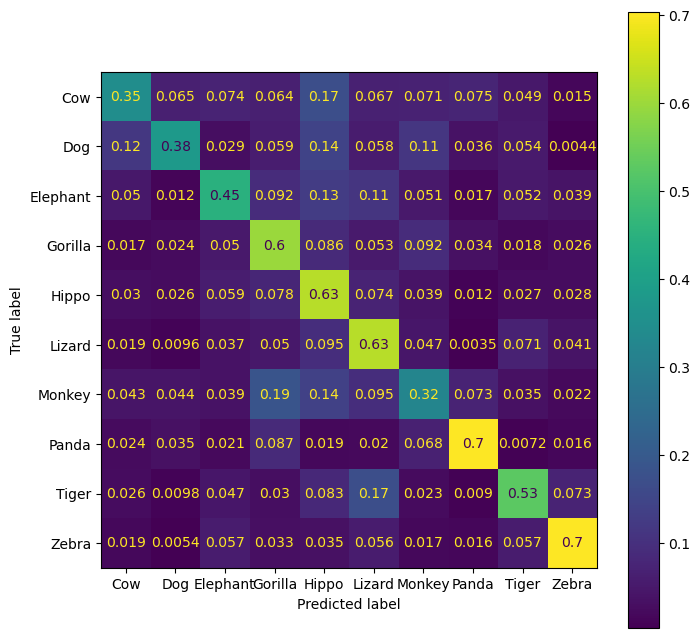

In [136]:
cm = confusion_matrix(true_labels, predicted_labels, normalize='true') 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax)
plt.show()

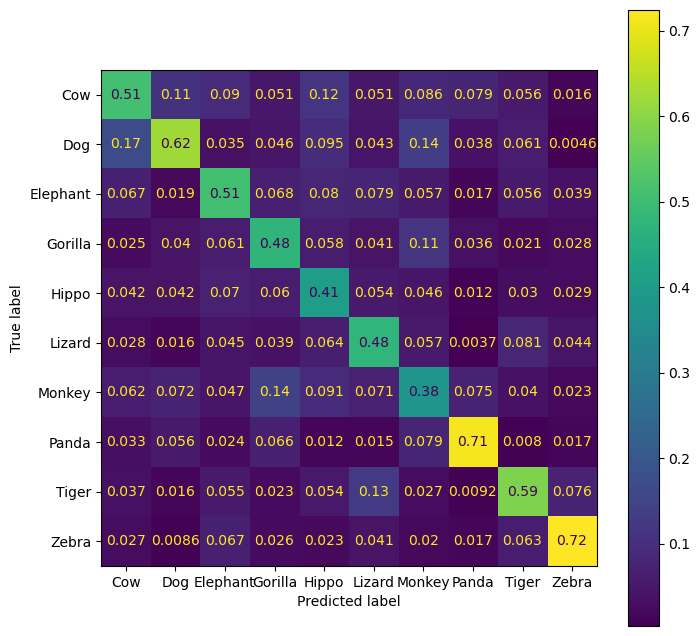

In [137]:
cm = confusion_matrix(true_labels, predicted_labels, normalize='pred') 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax)
plt.show()

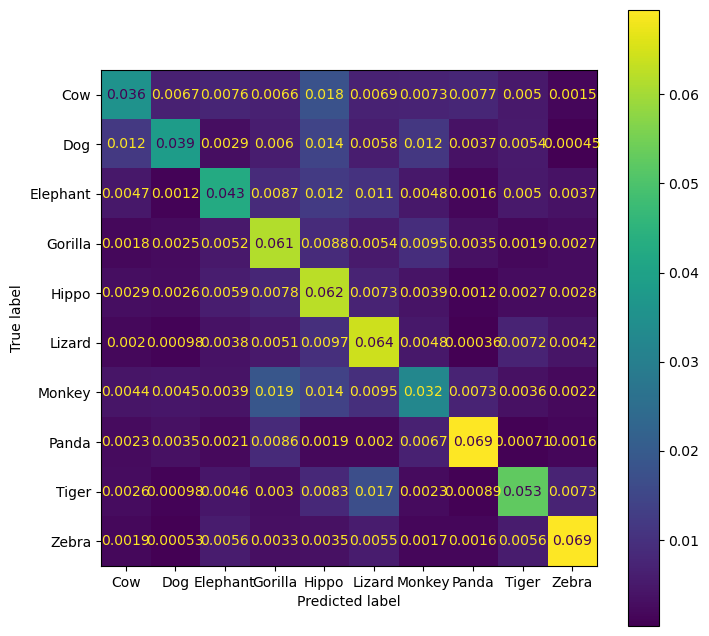

In [138]:
cm = confusion_matrix(true_labels, predicted_labels, normalize='all') 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax)
plt.show()

# TODO

## Discussion
Avoid stride>kernel-size (do you see why?)
disscuss underfitting

# Architecture 2

In [10]:
#https://towardsdatascience.com/a-guide-to-an-efficient-way-to-build-neural-network-architectures-part-ii-hyper-parameter-42efca01e5d7
#If you think that a big amount of pixels are necessary for the network to recognize the object you will use large filters (as 11x11 or 9x9). 
#If you think what differentiates objects are some small and local features you should use small filters (3x3 or 5x5)
# Note in general we use filters with odd sizes.

#The basic principle followed in building a convolutional neural network is 
#to ‘keep the feature space wide and shallow in the initial stages of the network, and the make it narrower and deeper towards the end.’

#Always start by using smaller filters is to collect as much local information as possible, and then gradually 
#increase the filter width to reduce the generated feature space width to represent more global, high-level and representative information

# By convention the number of channels generally increase or stay the same while we progress through layers in our convolutional neural net architecture

# Keep adding layers until you over-fit. 
#As once we achieved a considerable accuracy in our validation set we can use 
#regularization components like l1/l2 regularization, dropout, batch norm, data augmentation etc. to reduce over-fitting
#https://medium.com/@charlottecullip/a-comparison-of-cnn-architectures-part-2-8d03c67d8ec6
#https://www.geeksforgeeks.org/convolutional-neural-network-cnn-architectures/
#https://medium.com/@sajals1146/alexnet-architecture-993b760dec86

complex_model = models.Sequential()
# first
complex_model.add(layers.Conv2D(96, (6, 6),strides=2, activation='relu', input_shape=(img_height, img_width, img_channels)))
complex_model.add(layers.BatchNormalization())
# second
complex_model.add(layers.Conv2D(128, (5, 5), padding='same', activation='relu'))
complex_model.add(layers.BatchNormalization())
# third
complex_model.add(layers.MaxPooling2D((3, 3), strides=(2, 2)))
complex_model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
complex_model.add(layers.BatchNormalization())
#fourth
complex_model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
complex_model.add(layers.BatchNormalization())
#fifth
complex_model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
complex_model.add(layers.BatchNormalization())
complex_model.add(layers.MaxPooling2D((3, 3), strides=(2, 2)))
#deep
complex_model.add(layers.Flatten())
complex_model.add(layers.Dense(512, activation='relu'))
complex_model.add(layers.BatchNormalization())
complex_model.add(layers.Dense(256, activation='relu'))
complex_model.add(layers.BatchNormalization())
complex_model.add(layers.Dense(10))
complex_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 96)        10464     
                                                                 
 batch_normalization (BatchN  (None, 30, 30, 96)       384       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 128)       307328    
                                                                 
 batch_normalization_1 (Batc  (None, 30, 30, 128)      512       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                        

In [11]:
complex_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [12]:
# history dictionary for successive combined trainings
combined_complex_history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}

In [47]:
# save history data to disk
import json
# Save the dictionary to disk using JSON
with open('combined_history_complex_model.json', 'w') as f:
    json.dump(combined_complex_history, f)

In [8]:
# load history data from disk
import json

with open('combined_history_complex_model.json', 'r') as f:
    combined_complex_history = json.load(f)

In [15]:
# train
history = complex_model.fit(training_data, epochs=25, 
                           validation_data=validation_data)
# Update the combined_history with the first training session
for key in combined_complex_history.keys():
    combined_complex_history[key].extend(history.history[key])

Epoch 1/25


351/351 [==============================] - 101s 286ms/step - loss: 0.0776 - accuracy: 0.9752 - val_loss: 2.5340 - val_accuracy: 0.5291
Epoch 2/25
351/351 [==============================] - 105s 298ms/step - loss: 0.0777 - accuracy: 0.9747 - val_loss: 1.6180 - val_accuracy: 0.6864
Epoch 3/25
351/351 [==============================] - 104s 294ms/step - loss: 0.0550 - accuracy: 0.9825 - val_loss: 1.4428 - val_accuracy: 0.7270
Epoch 4/25
351/351 [==============================] - 104s 294ms/step - loss: 0.0580 - accuracy: 0.9814 - val_loss: 1.3352 - val_accuracy: 0.7471
Epoch 5/25
351/351 [==============================] - 103s 293ms/step - loss: 0.0661 - accuracy: 0.9771 - val_loss: 1.5983 - val_accuracy: 0.7015
Epoch 6/25
351/351 [==============================] - 103s 293ms/step - loss: 0.0815 - accuracy: 0.9736 - val_loss: 1.3247 - val_accuracy: 0.7328
Epoch 7/25
351/351 [==============================] - 105s 298ms/step - loss: 0.0580 - accuracy: 0.9816 - val_loss: 1.3243 - val_accura

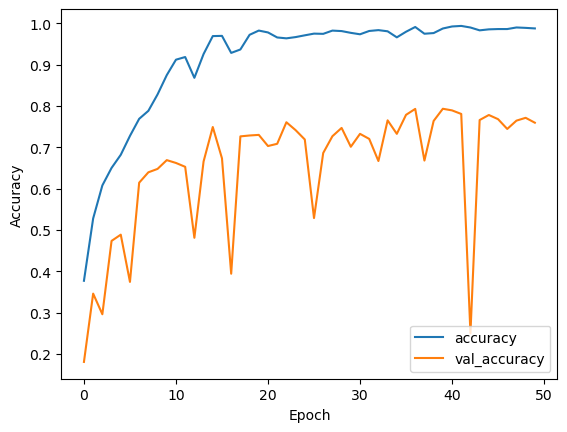

In [16]:
# plott accuracy
plt.plot(combined_complex_history['accuracy'], label='accuracy')
plt.plot(combined_complex_history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

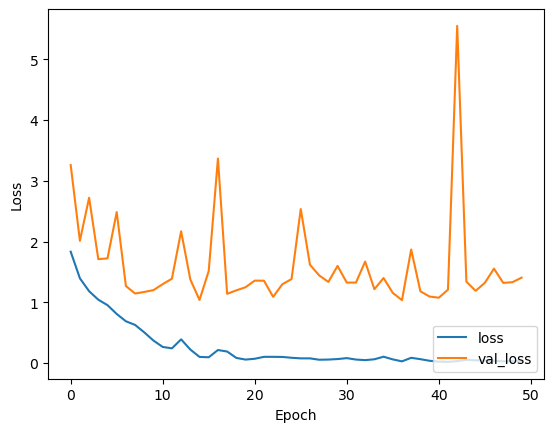

In [19]:
# plot error
plt.plot(combined_complex_history['loss'], label = 'loss')
plt.plot(combined_complex_history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()

In [20]:
print("validation data",complex_model.evaluate(training_data))
print("validation data",complex_model.evaluate(validation_data))

351/351 [==============================] - 45s 127ms/step - loss: 0.0419 - accuracy: 0.9856
validation data [0.0419001542031765, 0.9855563640594482]
87/87 [==============================] - 12s 141ms/step - loss: 1.3987 - accuracy: 0.7604
validation data [1.3987070322036743, 0.7604166865348816]


In [21]:
# save model to disk
complex_model.save("complex_model")

INFO:tensorflow:Assets written to: complex_model\assets


INFO:tensorflow:Assets written to: complex_model\assets


In [100]:
complex_model = tf.keras.models.load_model('complex_model')

## Confusion Matrix

In [124]:
predictions = complex_model.predict(training_data)

351/351 [==============================] - 49s 137ms/step


In [128]:
predicted_labels = np.array([])
true_labels = np.array([])

for x, y in training_data:
    predicted_labels = np.concatenate([predicted_labels,
                       np.argmax(complex_model(x), axis=-1)])
    true_labels = np.concatenate([true_labels, y])



In [129]:
print(true_labels)
print(predicted_labels)

[0. 9. 2. ... 0. 5. 3.]
[0. 9. 2. ... 0. 5. 3.]


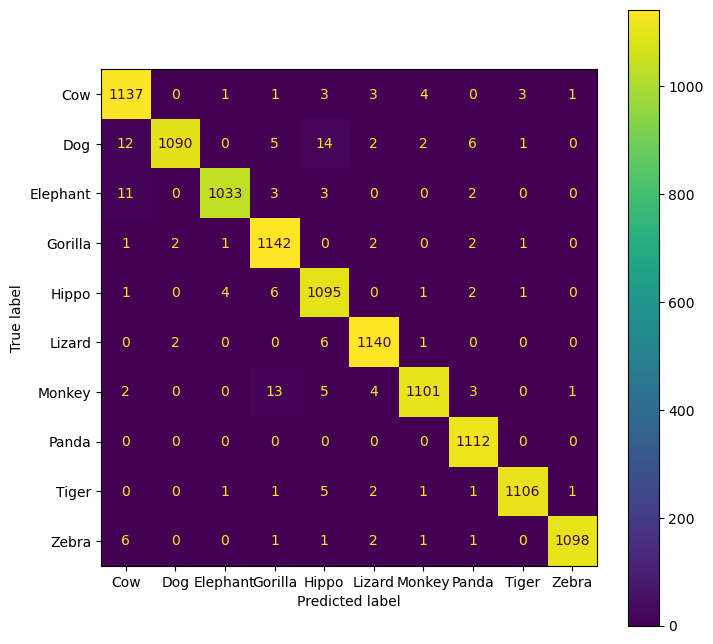

In [130]:
# ATTENTION: You cannot run the code like below (commented out),
# since tensorflow will reshuffle the data so that true and predictions do not match anymore!!!!
#predicted_labels = np.argmax(predictions, axis=-1) 
#print(predicted_labels)
#true_labels = np.concatenate([y.numpy() for _, y in training_data], axis=0) 
#print(true_labels)
cm = confusion_matrix(true_labels,predicted_labels) 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax)
plt.show()

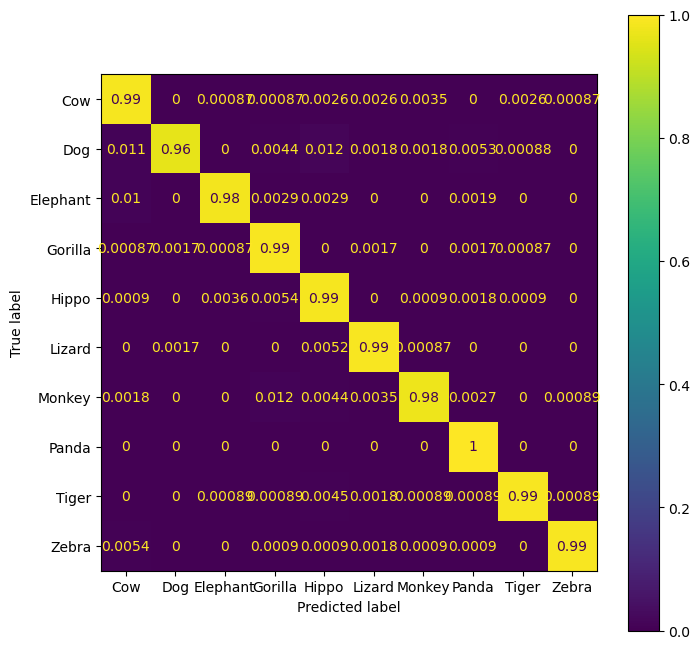

In [131]:
cm = confusion_matrix(true_labels, predicted_labels, normalize='true') 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax)
plt.show()

h) Plot a confusion matrix of the validation data. Make 3 different plots for 3 different values of the 
'normalize' parameter (see https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html )

Define and train a second model. Increase the number of layers, number of filters (=kernels), the 
number of neurons in the dense layer etc. Make the network too complex such that you observe 
overfitting. Depending on the dataset, you may need in the order of 105 to 106 parameters to see 
overfitting. 

k) As before, plot learning curves and confusion matrix. Make sure you observe (and document) 
overfitting.

l) Comment / discuss your model and the results.

1/1 [==============================] - 0s 145ms/step


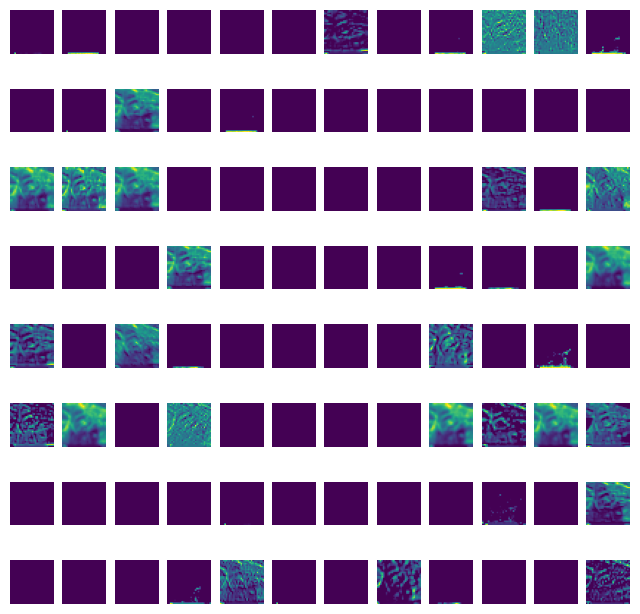

In [155]:

# Create a new model that includes only the layers up to the first convolutional layer
layer_outputs = [layer.output for layer in complex_model.layers[:2]]
activation_model = models.Model(inputs=complex_model.input, outputs=layer_outputs)

# Load the first image from the dataset
first_image = training_data.take(1)
for image, _ in first_image:
    img_tensor = image.numpy()
    break  # break after taking the first image

# Get activations
activations = activation_model.predict(img_tensor)

# Plot the first layer activations
first_layer_activation = activations[0]
plt.figure(figsize=(8, 8))
for i in range(96):  # Assuming 96 filters in the first layer
    plt.subplot(8, 12, i + 1)
    plt.imshow(first_layer_activation[0, :, :, i], cmap='viridis')
    plt.axis('off')

plt.show()

# Architecture 3

m) Make a copy of architecture 2 (that is, use exactly the same number of layers/neurons/kernels). 
Then optimize/regularize it:

n) Add at least one dropout layer. Set the dropout-rate to a value between 0.1 and 0.5
https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/

o) Add L2 regularization to the Conv-Layers and to the Dense-Layers by setting the parameters
kernel_regularizer=l2(lambda). Typical values for lambda are in the order of 10-6 to 10-3
https://machinelearningmastery.com/how-to-reduce-overfitting-in-deep-learning-with-weight-regularization/

p) Try different values for dropout-rate and lambda. Make sure you see a clear effect of regularization.
Try and report the following: As a test, you can use very high values for lambda and dropout-rate; 
the network should underfit. For very small (zero) regularization parameters, the network should 
again overfit. The optimal values are somewhere between these extremes.

q) Plot learning curves and confusion matrix 

r) Comment / discuss your model and the results.
Note: It is possible that the overfitted network has a better accuracy than the regularized model 
(for reasons we will discuss in class). On the other hand, the loss should be lower.

In [173]:
# https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/
complex_opt_model = models.Sequential()
# first
complex_opt_model.add(layers.Conv2D(96, (6, 6),strides=2, activation='relu' , kernel_regularizer=tf.keras.regularizers.l1(0.01), input_shape=(img_height, img_width, img_channels)))
complex_opt_model.add(layers.BatchNormalization())
complex_opt_model.add(layers.Dropout(0.2))

# second
complex_opt_model.add(layers.Conv2D(128, (5, 5), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01)))
complex_opt_model.add(layers.BatchNormalization())
complex_opt_model.add(layers.Dropout(0.2))
# third
complex_opt_model.add(layers.MaxPooling2D((3, 3), strides=(2, 2)))
complex_opt_model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01)))
complex_opt_model.add(layers.BatchNormalization())
complex_opt_model.add(layers.Dropout(0.2))
#fourth
complex_opt_model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01)))
complex_opt_model.add(layers.BatchNormalization())
complex_opt_model.add(layers.Dropout(0.2))
#fifth
complex_opt_model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01)))
complex_opt_model.add(layers.BatchNormalization())
complex_opt_model.add(layers.MaxPooling2D((3, 3), strides=(2, 2)))
complex_opt_model.add(layers.Dropout(0.2))
#deep
complex_opt_model.add(layers.Flatten())
complex_opt_model.add(layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01)))
complex_opt_model.add(layers.BatchNormalization())
complex_opt_model.add(layers.Dropout(0.2))
complex_opt_model.add(layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01)))
complex_opt_model.add(layers.BatchNormalization())
complex_opt_model.add(layers.Dropout(0.2))
complex_opt_model.add(layers.Dense(10))
complex_opt_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 30, 30, 96)        10464     
                                                                 
 batch_normalization_21 (Bat  (None, 30, 30, 96)       384       
 chNormalization)                                                
                                                                 
 dropout_15 (Dropout)        (None, 30, 30, 96)        0         
                                                                 
 conv2d_21 (Conv2D)          (None, 30, 30, 128)       307328    
                                                                 
 batch_normalization_22 (Bat  (None, 30, 30, 128)      512       
 chNormalization)                                                
                                                                 
 dropout_16 (Dropout)        (None, 30, 30, 128)      

In [174]:
complex_opt_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [176]:
# history dictionary for successive combined trainings
combined_complex_opt_history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}

In [175]:
# save history data to disk
import json
# Save the dictionary to disk using JSON
with open('combined_history_complex_model.json', 'w') as f:
    json.dump(combined_complex_opt_history, f)

In [ ]:
# load history data from disk
import json

with open('combined_history_complex_model.json', 'r') as f:
    combined_complex_opt_history = json.load(f)

In [177]:
# train
history = complex_opt_model.fit(training_data, epochs=10, 
                           validation_data=validation_data)
# Update the combined_history with the first training session
for key in combined_complex_opt_history.keys():
    combined_complex_opt_history[key].extend(history.history[key])

Epoch 1/10


351/351 [==============================] - 161s 447ms/step - loss: 108.1916 - accuracy: 0.1689 - val_loss: 34.1020 - val_accuracy: 0.0977
Epoch 2/10
224/351 [==================>...........] - ETA: 39s - loss: 30.6903 - accuracy: 0.1547

KeyboardInterrupt: 

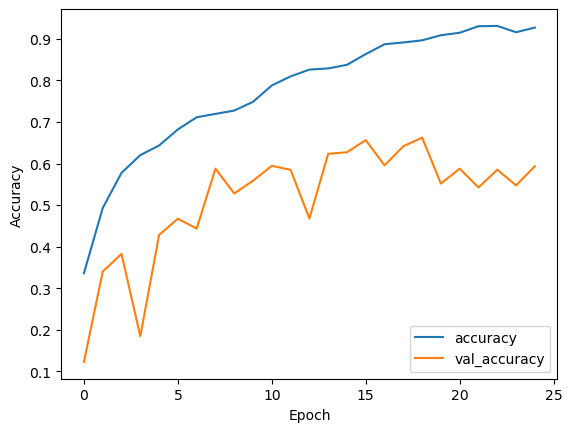

In [167]:
# plott accuracy
plt.plot(combined_complex_opt_history['accuracy'], label='accuracy')
plt.plot(combined_complex_opt_history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

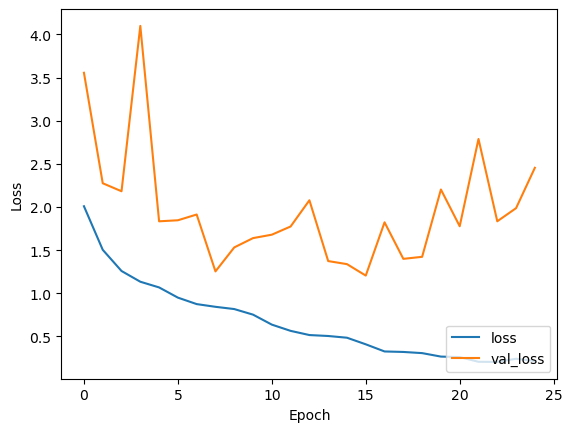

In [168]:
# plot error
plt.plot(combined_complex_opt_history['loss'], label = 'loss')
plt.plot(combined_complex_opt_history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()

In [169]:
print("validation data",complex_model.evaluate(training_data))
print("validation data",complex_model.evaluate(validation_data))

351/351 [==============================] - 53s 147ms/step - loss: 0.0417 - accuracy: 0.9856
validation data [0.04173388332128525, 0.9855563640594482]
87/87 [==============================] - 14s 154ms/step - loss: 1.4019 - accuracy: 0.7608
validation data [1.4018841981887817, 0.7607758641242981]


In [170]:
# save model to disk
complex_opt_model.save("complex_model")

INFO:tensorflow:Assets written to: complex_model\assets


INFO:tensorflow:Assets written to: complex_model\assets


In [ ]:
complex_opt_model = tf.keras.models.load_model('complex_model')

# Quantification of the model performance

s) Calculate the classification metrics Precision, Recall, F1 for the optimized model.
Use the material discussed in AI-Foundation or read articles on the web, for example: 
https://www.evidentlyai.com/classification-metrics ,
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html

t) Estimate the generalization error using k-fold Cross-Validation (CV) with k>=4. Report mean and 
std-dev of the generalization error (both, loss and accuracy). Compare these values with the 
previously reported loss and accuracy. Note: for CV, you create different splits of train_val_...
You still don't touch the test-set!
Optional:
Use CV to compare/select hyper-parameters (for example, find an optimal lambda): 
https://scikit-learn.org/stable/modules/cross_validation.html

u) Finally: evaluate the model performance using the test-set